In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/fs/cbsuvlaminck2/workdir/bmg224/hiprfish/image_analysis_code')
from segmentation import Segmentation
from image import Image
import image_functions as imfn
from tqdm import tqdm

In [7]:
data_dir = '../data/images'
factors = ['method', 'plasmid', 'fov']
sample_names = imfn.get_sample_names(data_dir=data_dir)
print(len(sample_names))
refl = ['gfp', 'cy5']
flat_field_filename = '/fs/cbsuvlaminck2/workdir/bmg224/hiprfish/utilities/2020_11_10_flat_field_correction_lens_100x_fov_3.czi'
flat_field_index = 2

62


In [8]:
keys = [imfn.get_filename_keys(sn, factors) for sn in sample_names]
sn_dict = imfn.get_nested_dict(keys, sample_names, [0,1,2])

In [10]:
fac = ['e','h','1']
sn = sn_dict[fac[0]][fac[1]][fac[2]][0][1]
im = Image(sample_name=sn, illumination_names=refl, data_dir=data_dir, 
           flat_field_filename=flat_field_filename, flat_field_index=flat_field_index)
im.pick_channel('cy5')
im.flat_field_correction()

In [31]:
import numpy as np
from matplotlib.colors import hsv_to_rgb
def get_two_channel_rgb(chan_hue, chan_white, hue=1/3, hue_clims=('min','max'), white_clims=('min','max')):
    # hue array is constant
    hue = np.zeros(chan_hue.shape) + hue
    # gather lims
    llims = []
    ulims = []
    for v, lims in zip([chan_hue, chan_white], [hue_clims, white_clims]):
        llims.append(np.min(v) if lims[0]=='min' else float(lims[0]))
        ulims.append(np.max(v) if lims[1]=='max' else float(lims[1]))
    # Set limits on saturation
    chan_white[chan_white < llims[1]] = llims[1]
    chan_white[chan_white > ulims[1]] = ulims[1]
    chan_white = (chan_white - llims[1]) / (ulims[1] - llims[1])
    # invert so that higher values are lower saturation
    saturation = (1 - chan_white)
    # Set limits on hue value
    chan_hue[chan_hue < llims[0]] = llims[0]
    chan_hue[chan_hue > ulims[0]] = ulims[0]
    # higher values are more hue, lower values are more black
    value = (chan_hue - llims[1]) / (ulims[1] - llims[1])
    # if 

    # Convert hsv to rgb
    hsv = np.dstack([hue, saturation, value])
    print(hsv[0,0,:])
    return hsv_to_rgb(hsv)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.          1.         -0.16187915]


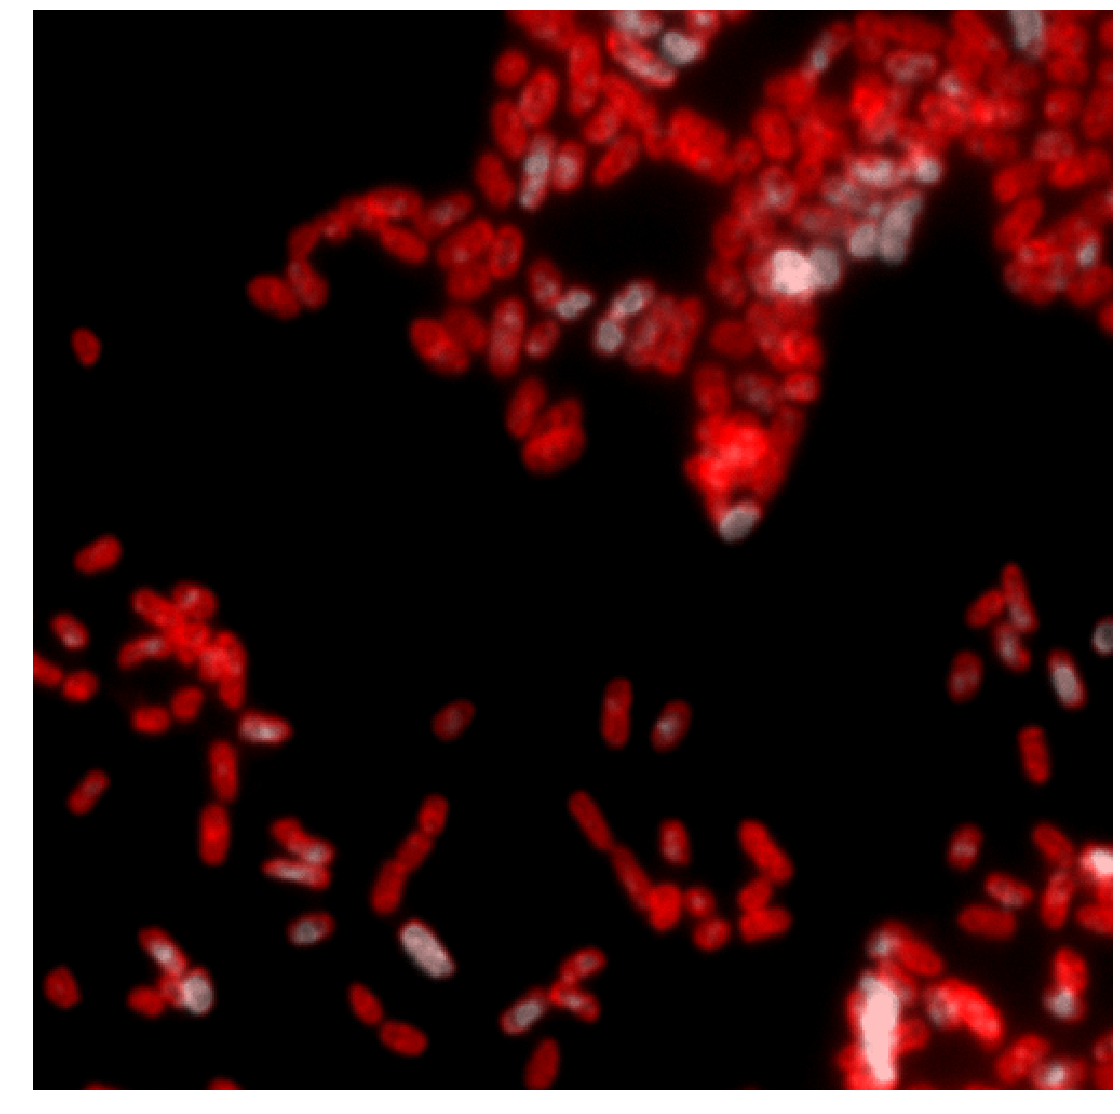

In [43]:
# cell_raw = np.zeros(im.raw_2D.shape) + 0.001
cell_raw = im.raw_stack[500:1000,500:1000,0]
spot_raw = im.raw_2D[500:1000,500:1000]
spot_clims = (0.05, 0.25)
cell_clims = ('min','max')
two_channel = get_two_channel_rgb(cell_raw, spot_raw, hue=0, hue_clims=cell_clims, white_clims=spot_clims)
dims = (15,15)
fig, ax = im._image_figure(dims)
imfn.plt.imshow(two_channel)